In [64]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from gensim.models import Word2Vec, KeyedVectors
from tqdm.auto import tqdm
from multiprocesspandas import applyparallel
from torch.utils.tensorboard import SummaryWriter


In [2]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
df = pandas.read_csv('data/merged.csv')

In [3]:
df = df.dropna(axis=1)

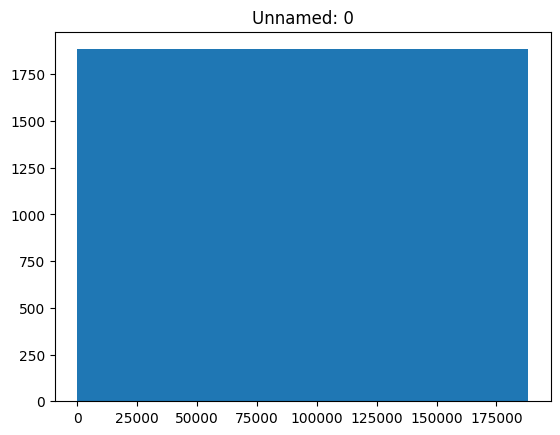

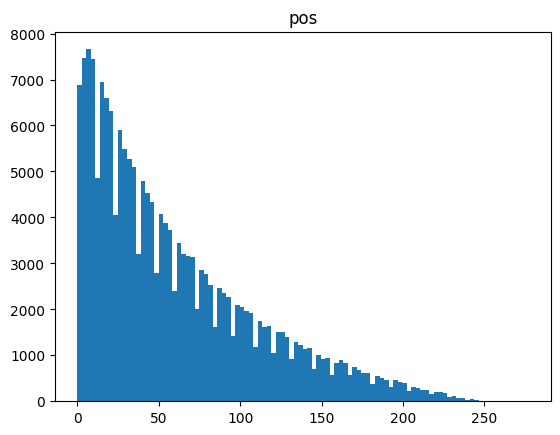

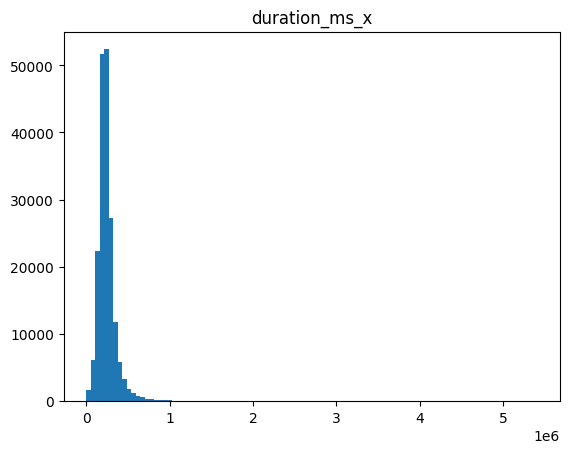

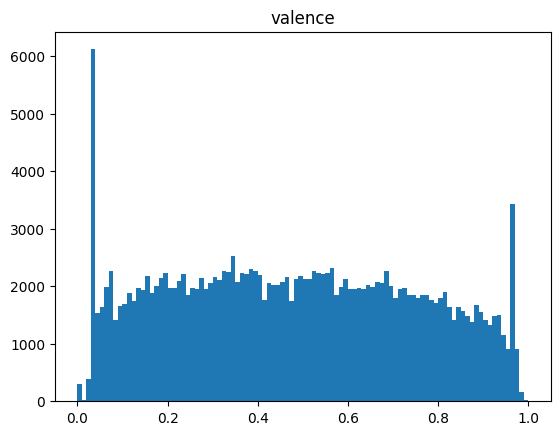

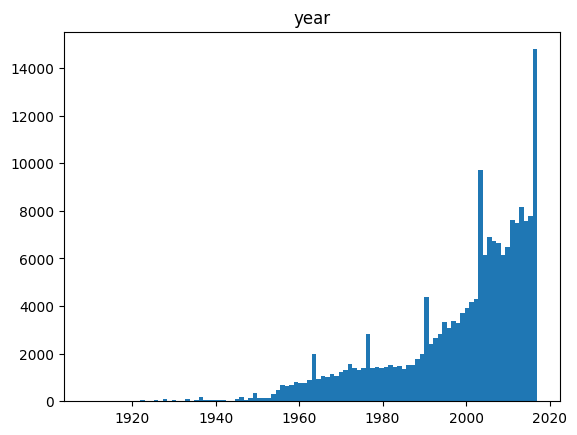

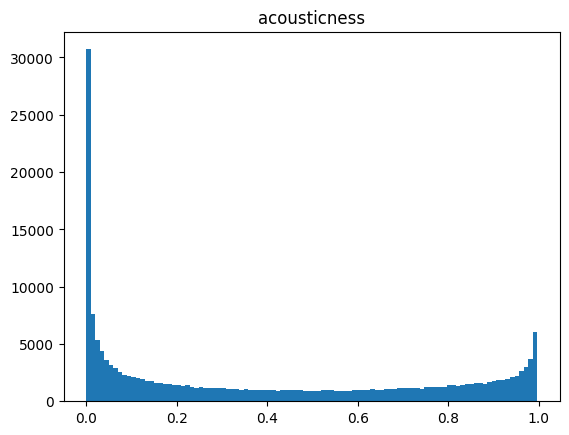

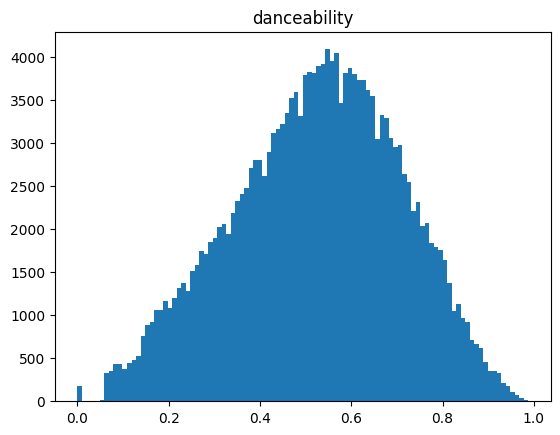

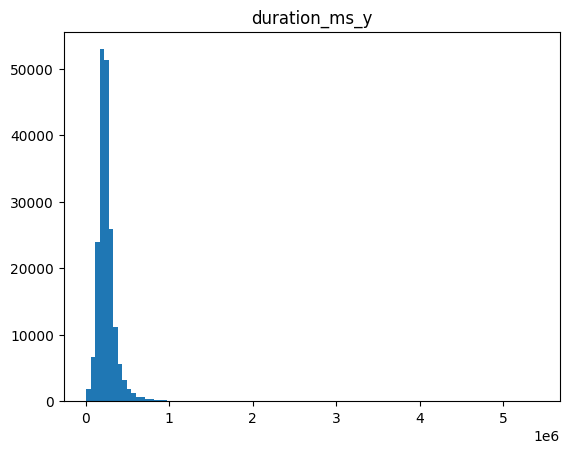

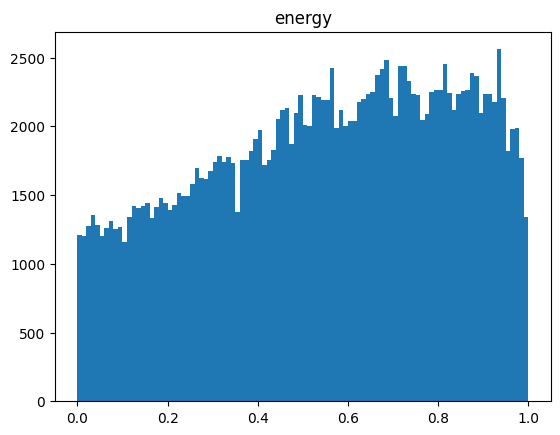

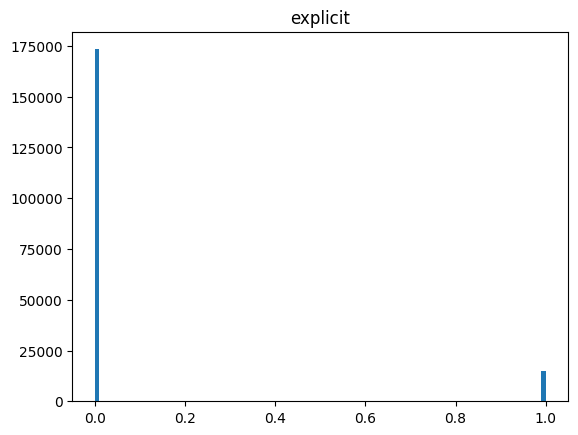

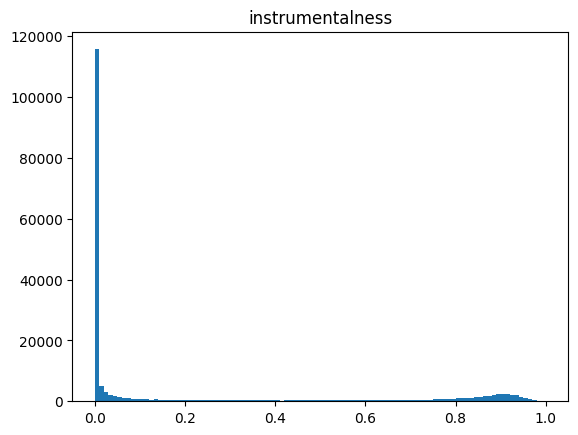

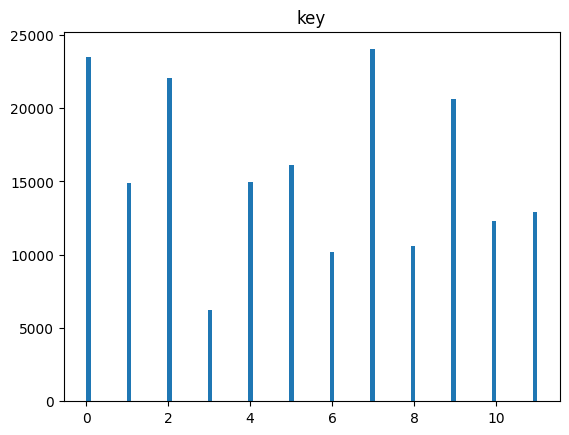

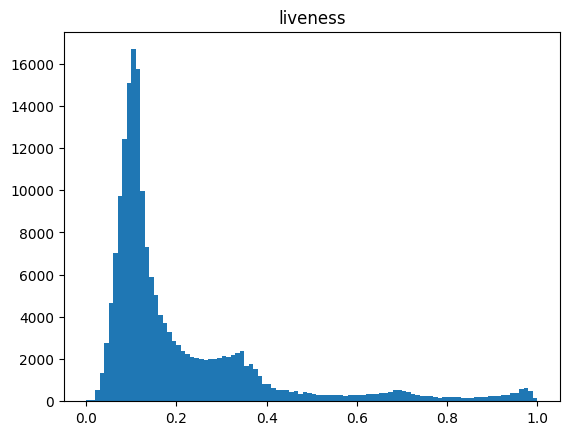

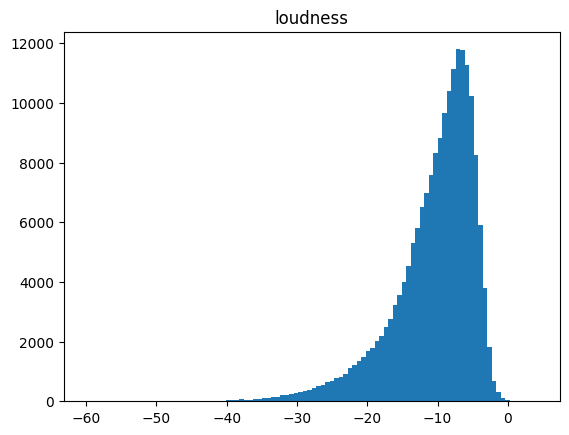

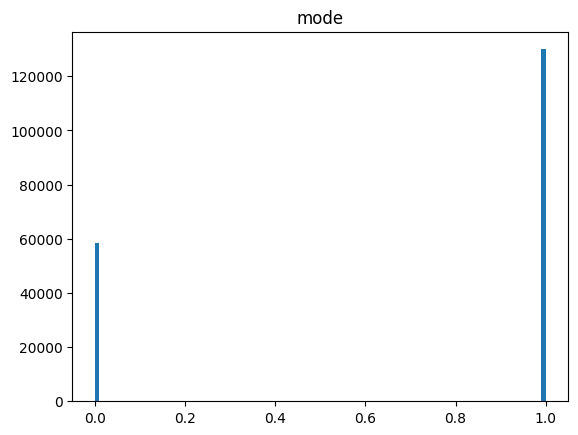

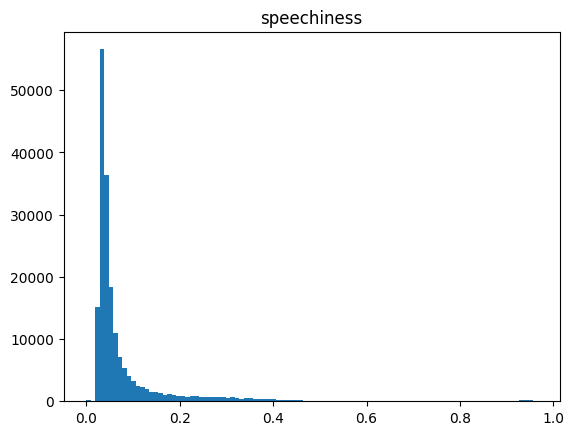

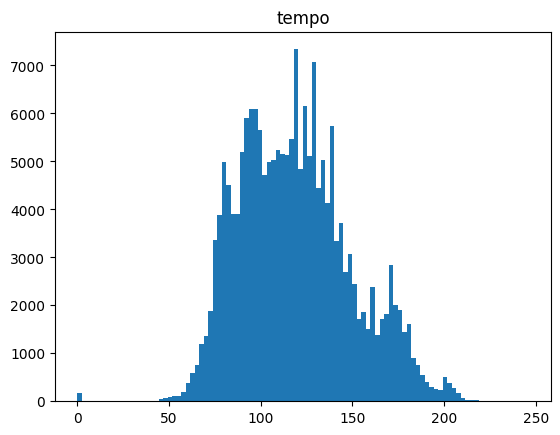

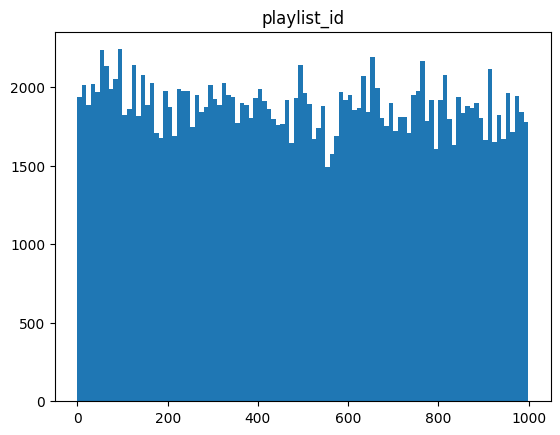

In [16]:
# Plot categorical data

numerical_data = df.select_dtypes(include=['float64', 'int64'])
for column in numerical_data:
    plt.figure()
    plt.hist(numerical_data[column], bins=100)
    plt.title(column)
    plt.show()


In [44]:
df.playlist_id.isna().sum()

0

In [42]:
df["acoustic_bin"] = df["acousticness"] > df["acousticness"].mean()
df["valence_bin"] = df["valence"] > df["valence"].mean()
df["instrumental_bin"] = df["instrumentalness"] > df["instrumentalness"].mean()

In [65]:
def generate_contrastive_pairs(df, n_pairs=1000):
    pairs = []
    first_song = df.sample(n=n_pairs, replace=False, axis=0)
    for i, song in tqdm(first_song.iterrows(), total=len(first_song)):
        same_playlist = df[df['playlist_id'] == song['playlist_id']].sample(n=1)["track_uri"].values[0]
        different_playlist = df[df['playlist_id'] != song['playlist_id']].sample(n=1)["track_uri"].values[0]

        same_instrumentalness = df[df['instrumental_bin'] == song['instrumental_bin']].sample(n=1)["track_uri"].values[0]
        different_instrumentalness = df[df['instrumental_bin'] != song['instrumental_bin']].sample(n=1)["track_uri"].values[0]

        same_valence = df[df['valence_bin'] == song['valence_bin']].sample(n=1)["track_uri"].values[0]
        different_valence = df[df['valence_bin'] != song['valence_bin']].sample(n=1)["track_uri"].values[0]

        same_acousticness = df[df['acoustic_bin'] == song['acoustic_bin']].sample(n=1)["track_uri"].values[0]
        different_acousticness = df[df['acoustic_bin'] != song['acoustic_bin']].sample(n=1)["track_uri"].values[0]

        same_mode = df[df['mode'] == song['mode']].sample(n=1)["track_uri"].values[0]
        different_mode = df[df['mode'] != song['mode']].sample(n=1)["track_uri"].values[0]

        same_key = df[df['key'] == song['key']].sample(n=1)["track_uri"].values[0]
        different_key = df[df['key'] != song['key']].sample(n=1)["track_uri"].values[0]
        
        same_explicit = df[df['explicit'] == song['explicit']].sample(n=1)["track_uri"].values[0]
        different_explicit = df[df['explicit'] != song['explicit']].sample(n=1)["track_uri"].values[0]

        pairs.append((song['track_uri'], same_playlist, 1))
        pairs.append((song['track_uri'], different_playlist, -1))
        pairs.append((song['track_uri'], same_instrumentalness, 1))
        pairs.append((song['track_uri'], different_instrumentalness, -1))
        pairs.append((song['track_uri'], same_valence, 1))
        pairs.append((song['track_uri'], different_valence, -1))
        pairs.append((song['track_uri'], same_acousticness, 1))
        pairs.append((song['track_uri'], different_acousticness, -1))
        pairs.append((song['track_uri'], same_mode, 1))
        pairs.append((song['track_uri'], different_mode, -1))
        pairs.append((song['track_uri'], same_key, 1))
        pairs.append((song['track_uri'], different_key, -1))
        pairs.append((song['track_uri'], same_explicit, 1))
        pairs.append((song['track_uri'], different_explicit, -1))
        
    return pairs

In [66]:
class ContrastiveDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

In [67]:
class ContrastiveModel(nn.Module):
    def __init__(self, input_size):
        super(ContrastiveModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size, bias=True)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [37]:
dataset = ContrastiveDataset(generate_contrastive_pairs(df, 1000))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = ContrastiveModel(256).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)    
writer = SummaryWriter()

  1%|          | 650/100000 [01:34<4:00:52,  6.87it/s]


KeyboardInterrupt: 

In [35]:
model = model.cuda()
loss_f = torch.nn.CosineEmbeddingLoss(margin=0.0, size_average=None, reduce=None, reduction='mean')

In [36]:
for epoch in tqdm(range(10)):
    for X, y, target in dataloader:
        X = wv[X].cuda()
        y = wv[y].cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = model(X)
        target_output = model(y)
        loss = loss_f(output, y, target)
        loss.backward()
        optimizer.step()
    dataset = ContrastiveDataset(generate_contrastive_pairs(df, 1000))
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    writer.add_scalar('Loss/train', loss, epoch)
    print(f"Epoch {epoch} loss: {loss.item()}")

 10%|█         | 1/10 [00:05<00:48,  5.41s/it]

Epoch 0 loss: 0.44282180070877075


 20%|██        | 2/10 [00:05<00:20,  2.51s/it]

Epoch 1 loss: 0.6591700315475464


 30%|███       | 3/10 [00:06<00:10,  1.56s/it]

Epoch 2 loss: 0.34569257497787476


 40%|████      | 4/10 [00:06<00:06,  1.12s/it]

Epoch 3 loss: 0.49625933170318604


 50%|█████     | 5/10 [00:07<00:04,  1.14it/s]

Epoch 4 loss: 0.5343070030212402


 60%|██████    | 6/10 [00:07<00:02,  1.37it/s]

Epoch 5 loss: 0.45863044261932373


 70%|███████   | 7/10 [00:08<00:01,  1.57it/s]

Epoch 6 loss: 0.3215894103050232


 80%|████████  | 8/10 [00:08<00:01,  1.74it/s]

Epoch 7 loss: 0.45880699157714844


 90%|█████████ | 9/10 [00:08<00:00,  1.87it/s]

Epoch 8 loss: 0.46599066257476807


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]

Epoch 9 loss: 0.3482588231563568


Mappeamos los tracks a vectores usando W2V, siguiendo [el siguiente paper](https://arxiv.org/pdf/2304.12257). Ahora debemos hacer el entrenamiento contrastivo sobre estos vectores, tomando en cuenta su coocurrencia en playlists (como menciona el paper), pero ademas la similitud de sus features de audio.